# T2D benchmark

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('../../')

In [2]:
import takco
conf = takco.Config('resources/config-dbpedia.toml')
t2dv2 = takco.TableSet.dataset('t2d-v2', **conf)

takco.preview(t2dv2)

In [124]:
%%time
import takco.link

kbs = {k.get("name", k.get("class")): takco.Config(k) for k in conf['kbs']}
# searcher_config = takco.Config({'name': 'dbpedialookup_t2ksubset'}, **kbs)
# searcher_config = takco.Config({'name': 'dbpedia_t2ksubset_extralabels'}, **kbs)
searcher_config = takco.Config({
    'name': 'es',
    'class': 'ElasticSearcher',
    'index': 'dbpediasub-6',
    'baseuri': 'http://dbpedia.org/resource/',
    'es_kwargs': {'hosts': ['bricks07']},
    'prop_uri': {'type': "http://www.w3.org/1999/02/22-rdf-syntax-ns#type"},
    'prop_baseuri': {'type': 'http://dbpedia.org/ontology/'},
})

pred = takco.TableSet.link(
    takco.DaskHashBag(list(t2dv2)[:10]),
    usecols = "keycol",
    lookup_config = None,
    linker_config = takco.Config({
        "class": "First",
        "limit": 1,
        "contextual": True,
        "search_limit": 5,
        "searcher": searcher_config,
        "majority_class": "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    }),
)
scored = takco.TableSet.score(pred, labels='t2d-v2', **conf)

report = takco.TableSet.report( scored, keycol_only=True, curve = True )

import pandas as pd
pd.DataFrame.from_dict( report.get('scores'), orient='index' )

CPU times: user 22.8 s, sys: 1.17 s, total: 23.9 s
Wall time: 25.4 s


precision    recall  f1-score  support  predictions
entities   0.910924  0.854216  0.881659     1269         1190
classes    1.000000  1.000000  1.000000       10           10

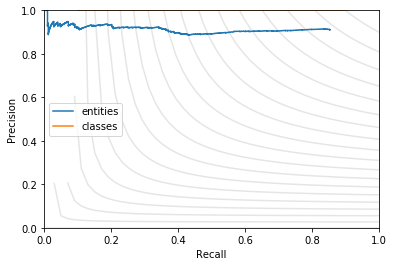

In [125]:
from takco.evaluate import pr_plot
pr_plot(report['curves'])

In [94]:
from takco.link import *

search = searcher_config.init_class(**globals())
print(search)
g = RDFSearcher(Trident(configuration='kb/dbpedia_t2ksubset/db/'))

missing_gold = []
mistake_gold = []
for table in scored:
    if table.get("gold", {}).get("entities"):
        for ci, ri_ents in table.get("gold", {}).get("entities").items():
            for ri, ents in ri_ents.items():
                for e in ents:
                    if e not in table.get("entities").get(ci, {}).get(ri, {}):
                        if not g.count([URIRef(e), None, None]):
                            missing_gold.append(e)
                        else:
                            row = [c.get('text') for c in table.get('tableData')[int(ri)]]
                            mistake_gold.append((e, (row, int(ci)) ))
                            
print('missing:', len(missing_gold), missing_gold[:50])
print()
print('mistake:', len(mistake_gold))


k = 3
for e, (row, ci) in mistake_gold[:100]:
    cell, context = row[ci], [c for ci2,c in enumerate(row) if ci2 != ci]
    rs = search.search_entities(cell, context, limit=k, add_about=True)
    is_in_top_k = (e in [r.uri for r in rs])
    if is_in_top_k:
        continue
    print(e.split('/')[-1])
    print(' ', f'"{cell}", {context}')
    print(' ', is_in_top_k, [r.uri.rsplit('/')[-1] for r in rs])
    print(' ', search.about(e))
    print()

missing: 49 ['http://dbpedia.org/resource/Goosebumps', 'http://dbpedia.org/resource/The_Exorcist', 'http://dbpedia.org/resource/The_Sun_Also_Rises', 'http://dbpedia.org/resource/Harry_Potter', 'http://dbpedia.org/resource/I_Know_Why_the_Caged_Bird_Sings', 'http://dbpedia.org/resource/Single-sex_education', "http://dbpedia.org/resource/Women_on_Top:_How_Real_Life_Has_Changed_Women's_Sexual_Fantasies", 'http://dbpedia.org/resource/Captain_Underpants', 'http://dbpedia.org/resource/On_My_Honor', 'http://dbpedia.org/resource/Sex_Education_(book)', 'http://dbpedia.org/resource/Arizona_Kid', 'http://dbpedia.org/resource/Punjab_Kesari', 'http://dbpedia.org/resource/Softpedia', 'http://dbpedia.org/resource/BBC_World_Service', 'http://dbpedia.org/resource/Media_of_Sierra_Leone', 'http://dbpedia.org/resource/Shanghai_IFC', 'http://dbpedia.org/resource/Hyperion_Tower', 'http://dbpedia.org/resource/Chongqing_World_Trade_Center', 'http://dbpedia.org/resource/Water_Tower_Place', 'http://dbpedia.org/r

In [121]:
import logging
# logging.getLogger().setLevel(logging.DEBUG)

from rdflib import RDF, RDFS, URIRef
from takco.link import *
search = takco.Config(searcher_config).init_class(**globals())

cell, context = "Singleton Hospital (Swansea)", []

results = search.search_entities(cell, context, limit=5, add_about=True)

print(len(results))
for i, sr in enumerate(results):
    types = sr.get(RDF.type) or []
    if URIRef('http://dbpedia.org/ontology/Book') in types or ('novel' in sr.uri) or True:
        print(i, sr.uri, sr.score, types, dict(sr))
    print()
    
logging.getLogger().setLevel(logging.WARN)

1
0 http://dbpedia.org/resource/Singleton_Hospital 36.89015 [] {'@id': 'http://dbpedia.org/resource/Singleton_Hospital', '@score': 36.89015, 'id': 'Singleton_Hospital', 'type': ['Hospital', 'Building'], 'surface': [{'value': 'singleton hospital', 'score': 1}, {'value': 'singleton hospital, swansea', 'score': 1}], 'context': ['Singleton Park', 'Abertawe Bro Morgannwg University Health Board', 'Swansea University', 'Swansea', 'Wales'], 'refs': 1, 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://dbpedia.org/ontology/Hospital', 'http://dbpedia.org/ontology/Building']}



In [119]:
takco.preview( scored, nrows=None, hide_correct_rows=True )

In [10]:
!time takco run -v -C resources/config-dbpedia.toml resources/pipelines/t2d-v2-baseline.toml

INFO:root:Set log level to 20
INFO:root:Loaded config {'name': 'config-dbpedia', 'datadir': 'data', 'resourcedir': 'resources', 'cache': False, 'kbs': [{'name': 'dbpedia_t2ksubset', 'class': 'RDFSearcher', 'labelProperties': ['http://dbpedia.org/ontology/title'], 'store': {'class': 'Trident', 'configuration': 'kb/dbpedia_t2ksubset/db/'}}, {'name': 'dbpedia_2014_part2', 'class': 'RDFSearcher', 'labelProperties': ['http://dbpedia.org/ontology/title'], 'store': {'class': 'Trident', 'configuration': 'kb/dbpedia/2014_part2/'}}, {'name': 'dbpedia_2016', 'class': 'RDFSearcher', 'labelProperties': ['http://dbpedia.org/ontology/title'], 'store': {'class': 'Trident', 'configuration': 'kb/dbpedia/2016-10/'}}, {'name': 'dbpedialookup', 'class': 'DBpediaLookup'}], 'assets': [{'name': 't2d-v1', 'class': 'T2D', 'download': ['http://webdatacommons.org/webtables/tables_instance.tar.gz', 'http://webdatacommons.org/webtables/entities_instance.tar.gz', 'http://webdatacommons.org/webtables/classes_instance